# Phase 3: Experiments with Supervised Contrastive Learning (SupCon)

### Reference:
- Paper: "Supervised Contrastive Learning" (Khosla et al., NeurIPS 2020)
- Code inspired by: https://github.com/HobbitLong/SupContrast

## 1. Setup & Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import random
from copy import deepcopy
from collections import defaultdict
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision
from torchvision import transforms

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm.auto import tqdm
import cv2
from PIL import Image
from pathlib import Path

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('✓ Imports successful!')

✓ Imports successful!


In [3]:
!rm -rf /content/drive


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')

Device: cuda
GPU: NVIDIA L4


In [6]:
# Configuration
NUM_CLASSES = 20

CLASS_NAMES = {
    0: 'Groove_billed_Ani', 1: 'Red_winged_Blackbird', 2: 'Rusty_Blackbird',
    3: 'Gray_Catbird', 4: 'Brandt_Cormorant', 5: 'Eastern_Towhee',
    6: 'Indigo_Bunting', 7: 'Brewer_Blackbird', 8: 'Painted_Bunting',
    9: 'Bobolink', 10: 'Lazuli_Bunting', 11: 'Yellow_headed_Blackbird',
    12: 'American_Crow', 13: 'Fish_Crow', 14: 'Brown_Creeper',
    15: 'Yellow_billed_Cuckoo', 16: 'Yellow_breasted_Chat',
    17: 'Black_billed_Cuckoo', 18: 'Gray_crowned_Rosy_Finch', 19: 'Bronzed_Cowbird'
}

CONFIG = {
    # Data paths
    'data_dir': '/content/drive/MyDrive/data',
    'train_csv': '/content/drive/MyDrive/data/train_metadata.csv',
    'val_csv': '/content/drive/MyDrive/data/val_metadata.csv',
    'combined_csv': '/content/drive/MyDrive/data/combined_metadata.csv',
    'train_images': '/content/drive/MyDrive/data/train_images',
    'val_images': '/content/drive/MyDrive/data/val_images',
    'combined_images': '/content/drive/MyDrive/data/combined_images',
    'test_images': '/content/drive/MyDrive/data/test_images/mistery_cat',
    'sample_submission': '/content/drive/MyDrive/data/sample_submission.csv',

    # External data (optional - for Noisy Student stage)
    'external_unlabeled_dir': 'external_birds_unlabeled/nabirds',
    'use_external_data': False,  # Set True for Noisy Student training
    'pseudo_label_confidence': 0.95,

    # SupCon pre-training params
    'supcon_img_size': 224,
    'supcon_batch_size': 32,
    'supcon_epochs': 100,  # More epochs for contrastive learning
    'supcon_lr': 0.5,  # Higher LR for contrastive
    'supcon_temperature': 0.07,  # Temperature for contrastive loss
    'supcon_projection_dim': 128,  # Projection head dimension

    # Fine-tuning params
    'finetune_img_size': 320,  # Larger for fine-tuning
    'finetune_batch_size': 24,
    'finetune_epochs': 40,
    'finetune_lr': 1e-4,  # Lower LR for fine-tuning

    # General
    'weight_decay': 1e-4,
    'num_workers': 4,

    # Output
    'checkpoint_dir': '/content/drive/MyDrive/ml_results/phase3b_checkpoints',
    'results_dir': '/content/drive/MyDrive/ml_results/phase3b_results',
}

os.makedirs(CONFIG['checkpoint_dir'], exist_ok=True)
os.makedirs(CONFIG['results_dir'], exist_ok=True)

print('✓ Phase 3 SupCon Configuration')
print(f"SupCon pre-training: {CONFIG['supcon_epochs']} epochs")
print(f"Fine-tuning: {CONFIG['finetune_epochs']} epochs")
print(f"Temperature: {CONFIG['supcon_temperature']}")
print(f"External data: {CONFIG['use_external_data']}")

✓ Phase 3 SupCon Configuration
SupCon pre-training: 100 epochs
Fine-tuning: 40 epochs
Temperature: 0.07
External data: False


## 2. Supervised Contrastive Loss Implementation

In [7]:
class SupConLoss(nn.Module):
    """
    Supervised Contrastive Learning Loss

    From: "Supervised Contrastive Learning" (Khosla et al., NeurIPS 2020)

    For each anchor, pull positives (same class) closer,
    push negatives (different class) farther.
    """
    def __init__(self, temperature=0.07, base_temperature=0.07):
        super().__init__()
        self.temperature = temperature
        self.base_temperature = base_temperature

    def forward(self, features, labels):
        """
        Args:
            features: [batch_size, projection_dim] - normalized embeddings
            labels: [batch_size] - ground truth labels

        Returns:
            Contrastive loss
        """
        device = features.device
        batch_size = features.shape[0]

        # Normalize features
        features = F.normalize(features, dim=1)

        # Create labels mask
        labels = labels.contiguous().view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(device)

        # Compute similarity matrix
        anchor_dot_contrast = torch.div(
            torch.matmul(features, features.T),
            self.temperature
        )

        # For numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # Mask to remove self-contrast
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # Compute log probability
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # Compute mean of log-likelihood over positives
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        # Loss
        loss = -(self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.mean()

        return loss

print('✓ SupConLoss implemented')

✓ SupConLoss implemented


## 3. SupCon Model Architecture

In [8]:
class SupConModel(nn.Module):
    """
    Encoder + Projection Head for Contrastive Learning
    """
    def __init__(self, base_model='convnext_tiny', projection_dim=128):
        super().__init__()

        # Encoder
        self.encoder = timm.create_model(base_model, pretrained=True, num_classes=0)  # Remove classification head

        # Get encoder output dimension
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224)
            encoder_dim = self.encoder(dummy_input).shape[1]

        # Projection head (2-layer MLP)
        self.projection_head = nn.Sequential(
            nn.Linear(encoder_dim, encoder_dim),
            nn.ReLU(),
            nn.Linear(encoder_dim, projection_dim)
        )

    def forward(self, x):
        # Encode
        features = self.encoder(x)

        # Project
        projections = self.projection_head(features)

        return projections, features

class LinearClassifier(nn.Module):
    """
    Linear classifier for fine-tuning stage
    """
    def __init__(self, encoder, num_classes=20):
        super().__init__()
        self.encoder = encoder

        # Get encoder output dimension
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224)
            encoder_dim = self.encoder(dummy_input).shape[1]

        # Classification head
        self.classifier = nn.Linear(encoder_dim, num_classes)

    def forward(self, x):
        features = self.encoder(x)
        logits = self.classifier(features)
        return logits

print('✓ Model architectures defined')

✓ Model architectures defined


## 4. Data Loading & Augmentation

In [9]:
# Load data
train_df = pd.read_csv(CONFIG['train_csv'])
val_df = pd.read_csv(CONFIG['val_csv'])
combined_df = pd.read_csv(CONFIG['combined_csv'])

print(f"Training samples: {len(train_df):,}")
print(f"Validation samples: {len(val_df):,}")
print(f"Combined samples: {len(combined_df):,}")
print(train_df['class_idx'].value_counts().sort_index())

Training samples: 1,082
Validation samples: 103
Combined samples: 1,185
class_idx
0     58
1     53
2     57
3     54
4     53
5     54
6     57
7     55
8     52
9     58
10    54
11    54
12    53
13    54
14    52
15    55
16    51
17    55
18    51
19    52
Name: count, dtype: int64


In [10]:
# SupCon augmentation: Strong augmentation for contrastive learning
supcon_transform = A.Compose([
    A.Resize(CONFIG['supcon_img_size'], CONFIG['supcon_img_size']),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.5),
    A.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1, p=0.8),
    A.OneOf([
        A.GaussNoise(var_limit=(10, 50)),
        A.GaussianBlur(blur_limit=(3, 7)),
    ], p=0.5),
    A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Fine-tuning augmentation: Moderate augmentation
finetune_train_transform = A.Compose([
    A.Resize(CONFIG['finetune_img_size'], CONFIG['finetune_img_size']),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=20, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.CoarseDropout(max_holes=4, max_height=40, max_width=40, p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Validation transform
val_transform = A.Compose([
    A.Resize(CONFIG['finetune_img_size'], CONFIG['finetune_img_size']),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

print('✓ Augmentation pipelines ready')

✓ Augmentation pipelines ready


In [11]:
class BirdDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['path'])
        label = row['class_idx']

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, label

# Create datasets for SupCon training
supcon_train_dataset = BirdDataset(train_df, CONFIG['train_images'], supcon_transform)
supcon_val_dataset = BirdDataset(val_df, CONFIG['val_images'], val_transform)

supcon_train_loader = DataLoader(
    supcon_train_dataset,
    batch_size=CONFIG['supcon_batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=True,
    drop_last=True  # Important for contrastive learning
)

supcon_val_loader = DataLoader(
    supcon_val_dataset,
    batch_size=CONFIG['supcon_batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

print(f"✓ SupCon data loaders ready")
print(f"Training batches: {len(supcon_train_loader)}")
print(f"Validation batches: {len(supcon_val_loader)}")

✓ SupCon data loaders ready
Training batches: 33
Validation batches: 4


## 5. STAGE 1: SupCon Pre-training

Train the encoder to learn discriminative features using contrastive loss.

In [12]:
def train_supcon(model, train_loader, val_loader, epochs, lr):
    """
    Train with Supervised Contrastive Loss
    """
    print("\n" + "="*70)
    print("STAGE 1: SUPERVISED CONTRASTIVE PRE-TRAINING")
    print("="*70)

    criterion = SupConLoss(temperature=CONFIG['supcon_temperature'])
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=lr,
        momentum=0.9,
        weight_decay=CONFIG['weight_decay']
    )

    # Cosine annealing
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    best_loss = float('inf')
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            projections, _ = model(images)

            # Contrastive loss
            loss = criterion(projections, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                projections, _ = model(images)
                loss = criterion(projections, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss: {val_loss:.4f}")
        print(f"  LR: {scheduler.get_last_lr()[0]:.6f}")

        # Save best model
        if val_loss < best_loss:
            best_loss = val_loss
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
            }
            torch.save(checkpoint, os.path.join(CONFIG['checkpoint_dir'], 'supcon_encoder_best.pth'))
            print(f"  ✓ Best model saved (loss: {best_loss:.4f})")

    print(f"\n✓ SupCon pre-training complete!")
    print(f"Best validation loss: {best_loss:.4f}")

    return model, history

print('✓ SupCon training function ready')

✓ SupCon training function ready


In [13]:
# Create SupCon model
supcon_model = SupConModel(
    base_model='convnext_tiny',
    projection_dim=CONFIG['supcon_projection_dim']
)
supcon_model = supcon_model.to(device)

print(f"Model created: ConvNeXt-Tiny with {CONFIG['supcon_projection_dim']}-dim projection")

# Count parameters
total_params = sum(p.numel() for p in supcon_model.parameters())
trainable_params = sum(p.numel() for p in supcon_model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Model created: ConvNeXt-Tiny with 128-dim projection
Total parameters: 28,509,152
Trainable parameters: 28,509,152


In [14]:
# Train SupCon model
supcon_model, supcon_history = train_supcon(
    model=supcon_model,
    train_loader=supcon_train_loader,
    val_loader=supcon_val_loader,
    epochs=CONFIG['supcon_epochs'],
    lr=CONFIG['supcon_lr']
)


STAGE 1: SUPERVISED CONTRASTIVE PRE-TRAINING


Epoch 1/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.499877


Epoch 2/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.499507


Epoch 3/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.498890


Epoch 4/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.498029


Epoch 5/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.496922


Epoch 6/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.495572


Epoch 7/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.493979


Epoch 8/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.492146


Epoch 9/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.490073


Epoch 10/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.487764


Epoch 11/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 11/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.485220


Epoch 12/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 12/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.482444


Epoch 13/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 13/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.479439


Epoch 14/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 14/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.476207


Epoch 15/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 15/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.472752


Epoch 16/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 16/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.469077


Epoch 17/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 17/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.465186


Epoch 18/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 18/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.461082


Epoch 19/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 19/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.456770


Epoch 20/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 20/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.452254


Epoch 21/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 21/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.447539


Epoch 22/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 22/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.442628


Epoch 23/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 23/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.437528


Epoch 24/100:   0%|          | 0/33 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d3786bbe160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d3786bbe160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 24/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.432242


Epoch 25/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 25/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.426777


Epoch 26/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 26/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.421137


Epoch 27/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 27/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.415328


Epoch 28/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 28/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.409356


Epoch 29/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 29/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.403227


Epoch 30/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 30/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.396946


Epoch 31/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 31/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.390521


Epoch 32/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 32/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.383957


Epoch 33/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 33/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.377260


Epoch 34/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 34/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.370438


Epoch 35/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 35/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.363498


Epoch 36/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 36/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.356445


Epoch 37/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 37/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.349287


Epoch 38/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 38/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.342031


Epoch 39/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 39/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.334684


Epoch 40/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 40/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.327254


Epoch 41/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 41/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.319748


Epoch 42/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 42/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.312172


Epoch 43/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 43/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.304536


Epoch 44/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 44/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.296845


Epoch 45/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 45/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.289109


Epoch 46/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 46/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.281333


Epoch 47/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 47/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.273527


Epoch 48/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 48/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.265698


Epoch 49/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 49/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.257853


Epoch 50/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 50/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.250000


Epoch 51/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 51/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.242147


Epoch 52/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 52/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.234302


Epoch 53/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 53/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.226473


Epoch 54/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 54/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.218667


Epoch 55/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 55/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.210891


Epoch 56/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 56/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.203155


Epoch 57/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 57/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.195464


Epoch 58/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 58/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.187828


Epoch 59/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 59/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.180252


Epoch 60/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 60/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.172746


Epoch 61/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 61/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.165316


Epoch 62/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 62/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.157969


Epoch 63/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 63/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.150713


Epoch 64/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 64/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.143555


Epoch 65/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 65/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.136502


Epoch 66/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 66/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.129562


Epoch 67/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 67/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.122740


Epoch 68/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 68/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.116043


Epoch 69/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 69/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.109479


Epoch 70/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 70/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.103054


Epoch 71/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 71/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.096773


Epoch 72/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 72/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.090644


Epoch 73/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 73/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.084672


Epoch 74/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 74/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.078863


Epoch 75/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 75/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.073223


Epoch 76/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 76/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.067758


Epoch 77/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 77/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.062472


Epoch 78/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 78/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.057372


Epoch 79/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 79/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.052461


Epoch 80/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 80/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.047746


Epoch 81/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 81/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.043230


Epoch 82/100:   0%|          | 0/33 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d3786bbe160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7d3786bbe160>^
Traceback (most recent call last):
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^^    ^self._shutdown_workers()
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^if w.is_alive():^
^ ^ ^

Epoch 82/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.038918


Epoch 83/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 83/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.034814


Epoch 84/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 84/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.030923


Epoch 85/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 85/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.027248


Epoch 86/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 86/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.023793


Epoch 87/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 87/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.020561


Epoch 88/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 88/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.017556


Epoch 89/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 89/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.014780


Epoch 90/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 90/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.012236


Epoch 91/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 91/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.009927


Epoch 92/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 92/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.007854


Epoch 93/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 93/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.006021


Epoch 94/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 94/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.004428


Epoch 95/100:   0%|          | 0/33 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d3786bbe160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d3786bbe160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 95/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.003078


Epoch 96/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 96/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.001971


Epoch 97/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 97/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.001110


Epoch 98/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 98/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.000493


Epoch 99/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 99/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.000123


Epoch 100/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 100/100:
  Train Loss: nan
  Val Loss: nan
  LR: 0.000000

✓ SupCon pre-training complete!
Best validation loss: inf


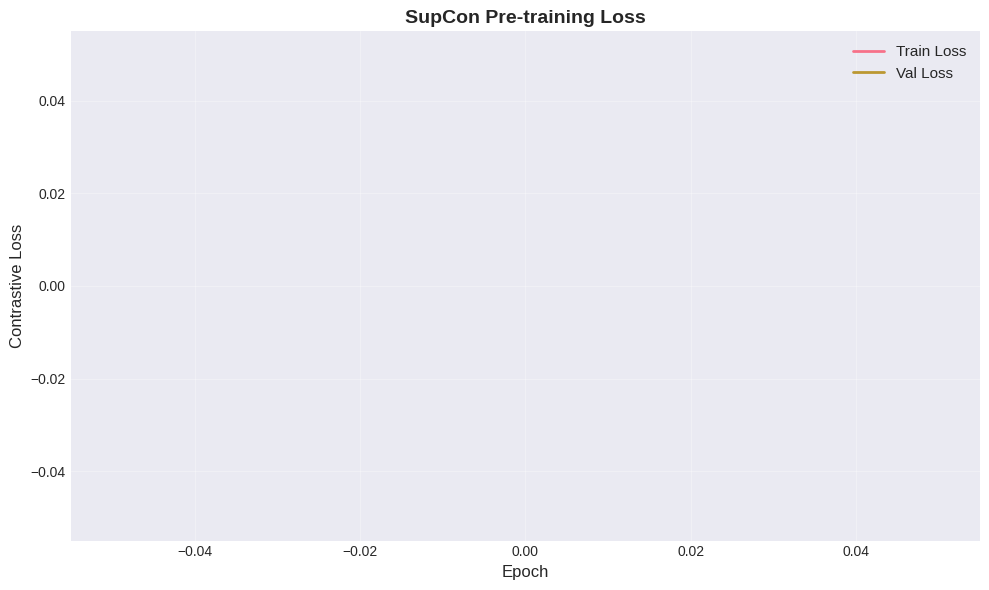

✓ Training curves saved


In [15]:
# Plot SupCon training curves
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(supcon_history['train_loss'], label='Train Loss', linewidth=2)
ax.plot(supcon_history['val_loss'], label='Val Loss', linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Contrastive Loss', fontsize=12)
ax.set_title('SupCon Pre-training Loss', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['results_dir'], 'supcon_training_curve.png'), dpi=150, bbox_inches='tight')
plt.show()

print('✓ Training curves saved')

## 6. STAGE 2: Classification Fine-tuning

Now that we have a good encoder, add a classification head and fine-tune.

In [16]:
# Load best SupCon encoder
checkpoint = torch.load(os.path.join(CONFIG['checkpoint_dir'], 'supcon_encoder_best.pth'))
supcon_model.load_state_dict(checkpoint['model_state_dict'])

# Create classification model
classifier_model = LinearClassifier(supcon_model.encoder, num_classes=NUM_CLASSES)
classifier_model = classifier_model.to(device)

print('✓ Loaded SupCon encoder')
print('✓ Created classification model')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/ml_results/phase3b_checkpoints/supcon_encoder_best.pth'

In [ ]:
# Create fine-tuning datasets (with larger images)
finetune_train_dataset = BirdDataset(train_df, CONFIG['train_images'], finetune_train_transform)
finetune_val_dataset = BirdDataset(val_df, CONFIG['val_images'], val_transform)

finetune_train_loader = DataLoader(
    finetune_train_dataset,
    batch_size=CONFIG['finetune_batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

finetune_val_loader = DataLoader(
    finetune_val_dataset,
    batch_size=CONFIG['finetune_batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

print(f"✓ Fine-tuning data loaders ready")
print(f"Image size: {CONFIG['finetune_img_size']}")

In [ ]:
def finetune_classifier(model, train_loader, val_loader, epochs, lr):
    """
    Fine-tune with cross-entropy loss
    """
    print("\n" + "="*70)
    print("STAGE 2: CLASSIFICATION FINE-TUNING")
    print("="*70)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
        weight_decay=CONFIG['weight_decay']
    )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = accuracy_score(all_labels, all_preds)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss: {val_loss:.4f}")
        print(f"  Val Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }
            torch.save(checkpoint, os.path.join(CONFIG['checkpoint_dir'], 'supcon_classifier_best.pth'))
            print(f"  ✓ Best model saved (acc: {best_acc:.4f})")

    print(f"\n✓ Fine-tuning complete!")
    print(f"Best validation accuracy: {best_acc:.4f}")

    return model, history, best_acc

print('✓ Fine-tuning function ready')

In [ ]:
# Fine-tune classifier
classifier_model, finetune_history, best_acc = finetune_classifier(
    model=classifier_model,
    train_loader=finetune_train_loader,
    val_loader=finetune_val_loader,
    epochs=CONFIG['finetune_epochs'],
    lr=CONFIG['finetune_lr']
)

In [ ]:
# Plot fine-tuning curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(finetune_history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(finetune_history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Fine-tuning Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(finetune_history['val_acc'], label='Val Accuracy', linewidth=2, color='green')
axes[1].axhline(y=best_acc, color='red', linestyle='--', label=f'Best: {best_acc:.4f}')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['results_dir'], 'finetune_curves.png'), dpi=150, bbox_inches='tight')
plt.show()

print('✓ Fine-tuning curves saved')

## 7. Evaluation & Confusion Matrix

In [ ]:
# Load best fine-tuned model
checkpoint = torch.load(os.path.join(CONFIG['checkpoint_dir'], 'supcon_classifier_best.pth'))
classifier_model.load_state_dict(checkpoint['model_state_dict'])
classifier_model.eval()

# Get predictions
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(finetune_val_loader, desc="Evaluating"):
        images = images.to(device)
        outputs = classifier_model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

final_acc = accuracy_score(all_labels, all_preds)
print(f"\n✓ Final Validation Accuracy: {final_acc:.4f}")

In [ ]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[CLASS_NAMES[i].replace('_', ' ') for i in range(NUM_CLASSES)],
            yticklabels=[CLASS_NAMES[i].replace('_', ' ') for i in range(NUM_CLASSES)],
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('True', fontsize=12, fontweight='bold')
plt.title(f'SupCon Model - Confusion Matrix (Acc: {final_acc:.4f})', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['results_dir'], 'confusion_matrix.png'), dpi=150, bbox_inches='tight')
plt.show()

print('✓ Confusion matrix saved')

In [ ]:
# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
per_class_df = pd.DataFrame({
    'Class': [CLASS_NAMES[i].replace('_', ' ') for i in range(NUM_CLASSES)],
    'Accuracy': per_class_acc,
    'Count': cm.sum(axis=1)
}).sort_values('Accuracy')

print("\nPer-class Accuracy:")
print(per_class_df.to_string(index=False))

# Save to CSV
per_class_df.to_csv(os.path.join(CONFIG['results_dir'], 'per_class_accuracy.csv'), index=False)
print("\n✓ Per-class accuracy saved")

## 8. Multi-Scale TTA for Final Predictions

In [ ]:
def predict_with_multiscale_tta(model, image, scales=[288, 320, 352], n_tta=5):
    """
    Multi-scale + TTA prediction
    """
    tta_transforms = [
        A.Compose([A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ToTensorV2()]),
        A.Compose([A.HorizontalFlip(p=1.0), A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ToTensorV2()]),
        A.Compose([A.Rotate(limit=10, p=1.0), A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ToTensorV2()]),
        A.Compose([A.Rotate(limit=-10, p=1.0), A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ToTensorV2()]),
        A.Compose([A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=5, p=1.0),
                   A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ToTensorV2()]),
    ]

    all_predictions = []

    model.eval()
    with torch.no_grad():
        for scale in scales:
            for tta in tta_transforms[:n_tta]:
                resized = cv2.resize(image, (scale, scale))
                augmented = tta(image=resized)['image']
                augmented = augmented.unsqueeze(0).to(device)

                output = model(augmented)
                probs = F.softmax(output, dim=1)
                all_predictions.append(probs.cpu().numpy())

    avg_pred = np.mean(all_predictions, axis=0)
    return avg_pred

print('✓ Multi-scale TTA function ready')
print('Predictions per image: 3 scales × 5 augmentations = 15')

In [ ]:
# Generate final submission
test_df = pd.read_csv(CONFIG['sample_submission'])
predictions = []

print("\n" + "="*70)
print("GENERATING FINAL PREDICTIONS WITH MULTI-SCALE TTA")
print("="*70)

for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Predicting"):
    img_path = os.path.join(CONFIG['test_images'], row['path'])
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    avg_pred = predict_with_multiscale_tta(
        classifier_model,
        image,
        scales=[288, 320, 352],
        n_tta=5
    )
    pred_class = np.argmax(avg_pred)
    predictions.append(pred_class)

# Create submission
submission = pd.DataFrame({
    'path': test_df['path'],
    'class_idx': predictions
})

submission_path = os.path.join(
    CONFIG['results_dir'],
    'submission_phase3_supcon.csv'
)
submission.to_csv(submission_path, index=False)

print(f"\n✓ Submission saved: {submission_path}")
print(f"Total predictions: {len(predictions)}")
print(f"\nPrediction distribution:")
print(pd.Series(predictions).value_counts().sort_index())